## Data preparation and sanitization

,prop,other_resp,other_prop,time_spent_risk,cells,selfish,time_spent_prop,count_effort,Honesty_Humility,Extraversion,Agreeableness,min_offer
0,50,50,50,43000,26,60,31000,20,4.2,3.0,2.8,50
1,50,20,20,12000,7,20,38000,20,1.9,4.4,2.9,50
2,120,50,80,88000,50,20,69000,12,3.3,3.8,3.4,80
3,50,50,50,24000,50,60,26000,14,3.6,3.8,2.6,50
4,100,50,50,137000,24,60,43000,4,3.6,2.5,2.7,100


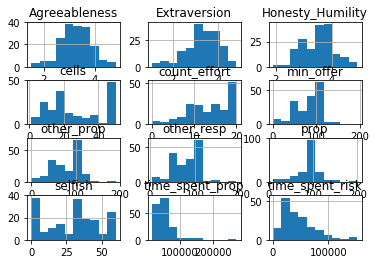

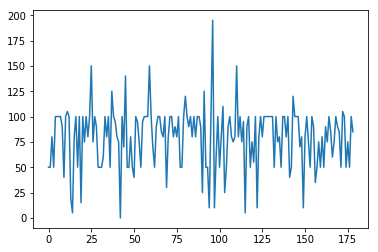

In [107]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

# Read and sanitize the data
df = pd.read_excel("./UG_HH_NEW_continuous_no200.xls")
df = df.dropna()

#print(df[50:])

# Show head and histograms
display(df.head())
df.hist()

# Plot sample figure for min_offers
plt.figure()

x = range(0, len(df['prop']))
x1 = df['min_offer']

plt.plot(x, x1)

## Linear regression (continuous dataset)

R2: -0.033486332886982995


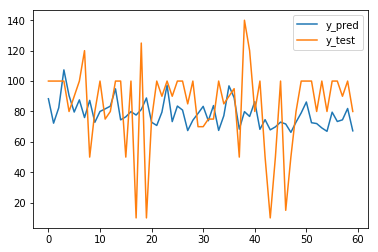

In [108]:
from sklearn.linear_model import LinearRegression

# Split into inputs and oututs
# NOTE: we skip the proposal, and responses (frist 3 values)
x = df.iloc[:, 3:-1].values

y = df.iloc[:, -1:].values

NB_FEATURES = x.shape[1]

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)

regressor = LinearRegression(copy_X=True).fit(xTrain, yTrain)

yPredict = regressor.predict(xTest)
print("R2:", r2_score(yTest, yPredict))

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPredict)})

out_data.plot()

In [122]:
#keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import multiply
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import sys

def simple_model(loss=None, metrics=None):
    """
    build a simple regression model
    :param loss: (str|callable, default: mse)
    """
    drop_rate = 0.05
    if loss is None:
        loss = "mse"
    model = Sequential()
    model.add(Dense(5, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='rmsprop', metrics=metrics)
    return model

**Accuracies**

** Gain and Losses **

In [123]:
loss_baseline = "mse"
MAX_GAIN = 200.0


def gain_tf(min_offer, predicted):
    base = MAX_GAIN - predicted
    less = tf.less(predicted, min_offer)
    zero = tf.zeros_like(min_offer)
    res = tf.where(less, zero, base)
    res = tf.where(tf.less(res, 0), zero, res)
    return res

def gain_mean_tf(min_offer, predicted):
    return K.mean(gain_tf(min_offer, predicted))

def gain_ratio_tf(min_offer, predicted):
    act_gain = gain_tf(min_offer, predicted)
    max_gain = gain_tf(min_offer, min_offer)
    return K.mean(act_gain/max_gain)


def gain(min_offer, predicted):
    """arrays"""
    predicted[predicted < 0] = 0
    predicted[predicted > MAX_GAIN] = MAX_GAIN
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res

def gain_mean(min_offer, predicted):
    return gain(min_offer, predicted).mean()

def gain_ratio(min_offer, predicted):
    """
    :returns: The ratio of the maximal possible gain based on min_offer
    """
    act_gain = gain(min_offer, predicted)
    max_gain = gain(min_offer, min_offer)
    return (act_gain/max_gain).mean()

#Loss according to the first idea
def loss(predicted, min_offer):
    return (MAX_GAIN-min_offer)**2 if predicted < min_offer else 0.5*(predicted - min_offer)**2

def loss_(min_offer, predicted):
    #res = predicted.copy()
    #ge = K.greater_equal(predicted, min_offer)
    #sub = tf.math.where
    return K.mean(K.square(tf.math.subtract(min_offer, predicted)))
           
def loss_gain(y_true, y_pred):
    #y_true = K.print_tensor(y_true,message='y_true:')
    #y_pred = K.print_tensor(y_pred,message='y_pred:')
    ge = K.greater_equal(y_pred, y_true)
    less = K.less(y_pred, y_true)
    #ge = K.print_tensor(ge,message='ge:')
    sub = tf.math.subtract(y_pred, y_true)
    part1 = tf.where(ge, y_true, sub)
    part2 = tf.where(less, y_true, tf.constant(MAX_GAIN))
    re = tf.math.add(part1, part2)
    #re = K.print_tensor(re,message='re:')
    #return K.abs(re)
    return K.square(re)

def loss_gain(y_true, y_pred):
    max_gain = tf.constant(MAX_GAIN)
    res = tf.math.subtract(y_true, y_true)
    res = tf.math.add(max_gain, res)
    ge = K.greater_equal(y_pred, y_true)
    less = K.less(y_pred, y_true)
    sub = tf.math.subtract(max_gain, y_true)
    res = tf.where(ge, res, sub)
    return res**2
    #return tf.math.exp(res)
    #return tf.math.square(tf.math.abs(tf.math.subtract(y_true, y_pred)))

def loss_gain(y_true, y_pred):
    max_gain = tf.constant(MAX_GAIN)
    res = tf.math.subtract(y_true, y_true)
    res = tf.math.add(max_gain, res)
    ge = K.greater_equal(y_pred, y_true)
    less = K.less(y_pred, y_true)
    sub = tf.math.subtract(max_gain, y_true)
    res = tf.where(ge, res, sub)
    return res**2

def loss_gain_mse(y_true, y_pred):
    return K.square(loss_gain(y_true, y_pred))

def loss_gain_cont(y_true, y_pred):
    left = (y_true - y_pred) ** 4
    right = tf.math.abs(y_pred - y_true) ** 2
    ge = K.greater_equal(y_pred, y_true)
    res = tf.where(ge, right, left)
    return res

def loss_gain_sigmoid(y_true, y_pred):
    diff = tf.math.abs(y_pred - y_true)
    diff = tf.math.divide(diff, 50) #==> max possible value is now 4
    diff_left = tf.math.pow(diff, 32)
    diff_right = tf.math.pow(diff, 2)
    ge = K.greater_equal(y_pred, y_true)
    base = tf.where(ge, diff_right, diff_left)
    return (base)/(base + 1)

def loss_gain_simgoid(y_true, y_pred):
    diff = tf.math.abs(y_pred - y_true)
    diff
    

def loss_mse(y_true, y_pred):
    return K.mean((y_true - y_pred) ** 2)

def loss_mse_offset(y_true, y_pred):
    offset = 1.4
    return K.mean((y_true - (y_pred - offset)) ** 2)

def loss_mean_pred(y_true, y_pred):
    max_gain = tf.constant(MAX_GAIN)
    return tf.math.abs(tf.math.subtract(max_gain, (y_pred)))


Results: 2.83 (1.23) MSE, Scalar test loss: 7305.61


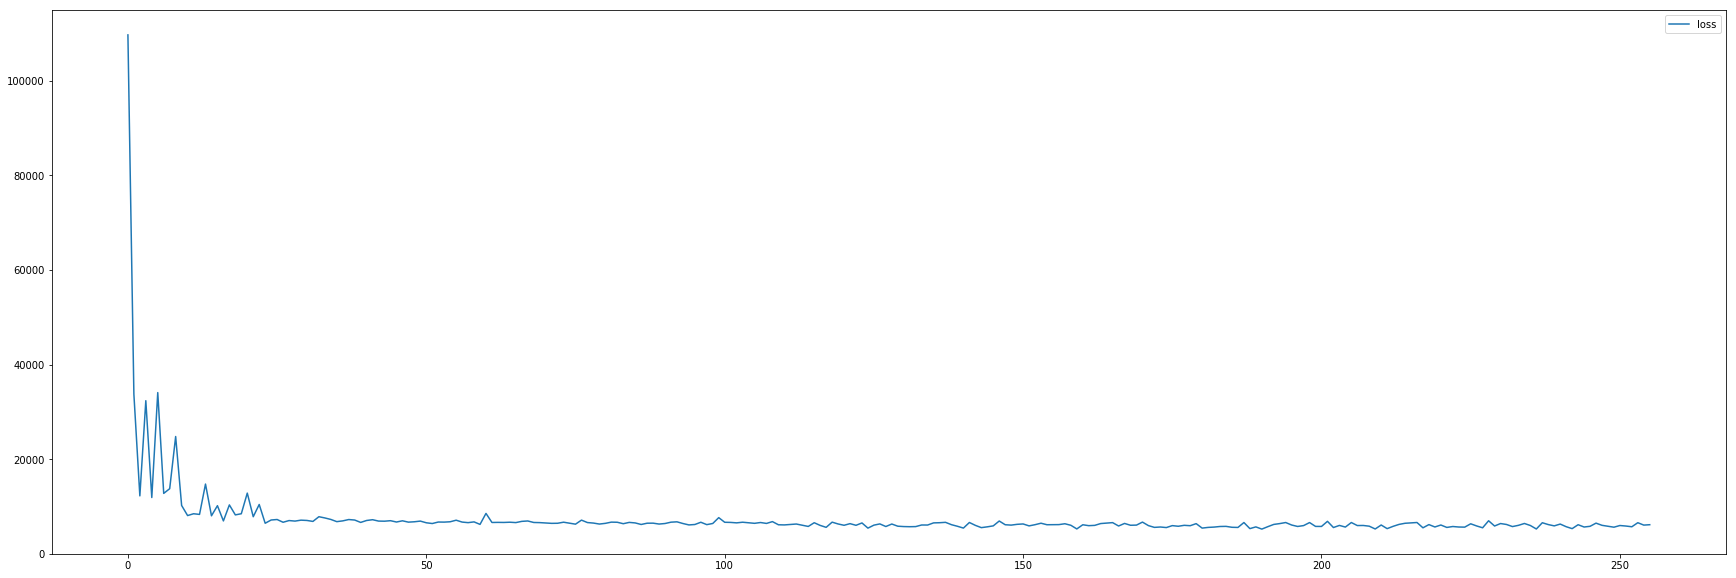

In [124]:
#sci-kit like training
sm = simple_model("mse") 
yTrainSteps = np.copy(yTrain)
for i in range(10, 200, 10):
    mask = (yTrainSteps > i) & (yTrainSteps <= (i+10))
    yTrainSteps[mask] = i+10
history = sm.fit(xTrain, yTrainSteps, validation_split=0.33, epochs=256, batch_size=64, verbose=0)
loss_hist = pd.DataFrame(data={'loss': history.history['loss']})
loss_hist.plot(figsize=(30,10))
smPredict = sm.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(smPredict)})
stl = sm.evaluate(xTest, yTest, verbose=0)
print("Results: %2.2f (%.2f) MSE, Scalar test loss: %.2f" % (smPredict.mean(), smPredict.std(), stl))
#out_data.plot(figsize=(30,10))

In [125]:
xTrain.shape

(119, 8)

In [126]:
gain_mean(yTest, smPredict)

0.0

In [127]:
from sklearn.model_selection import KFold
import numpy as np

def process_mlp(xTrain, yTrain, xTest, yTest, loss, metrics=None, validation_split=0.33, epochs=100, batch_size=8, verbose=0):
    for i in range(10, 200, 10):
        mask = (yTrain > i) & (yTrain < (i+10))
        #yTrain[mask] = i+10+5
    model = simple_model(loss, metrics)
    history = model.fit(xTrain, yTrain, validation_split=validation_split, epochs=epochs, batch_size=batch_size, verbose=verbose)
    yPredict = model.predict(xTest, batch_size=16)
    gr = gain_ratio(yTest, yPredict)
    return gr
    
def process_mlp_cv(X, y, loss, cv=5, metrics=None):
    kf = KFold(n_splits=cv)
    grs = []
    for train_index, test_index in kf.split(X):
        xTrain, yTrain = X[train_index], y[train_index]
        xTest, yTest = X[test_index], y[test_index]
        gr = process_mlp(xTrain, yTrain, xTest, yTest, loss, metrics, validation_split=1/4)
        grs.append(gr)
    if len(grs) > 0:
        return np.mean(grs), np.std(grs)
    return 0, 0
        
        
    

**Observation of the the "accuracy" *gain_ratio* **

**Cross validation checking mse, mse+offset(poor), and loss_gain**

In [128]:
#process_mlp_cv(x, y, loss_mse)

In [129]:
#process_mlp_cv(x, y, loss_mse_offset)

In [130]:
#process_mlp_cv(x, y, loss_gain_cont)

In [131]:
#process_mlp_cv(x, y, "mse")

**Fixed value model**

In [ ]:
abs(smPredict - yTest).mean()

In [133]:
yTrain_ = sm.predict(xTrain)

In [134]:
abs(yTrain_ - yTrain).mean()

74.95133534599753

In [136]:
from sklearn.mixture import BayesianGaussianMixture

In [145]:
bayes = BayesianGaussianMixture(n_components=10)
bayes.fit(xTrain, yTrain)
bayes.predict(xTest)

array([9, 0, 9, 4, 1, 7, 1, 7, 1, 7, 7, 7, 7, 1, 0, 9, 9, 0, 5, 1, 9, 0,
       7, 1, 0, 0, 0, 9, 7, 3, 5, 0, 0, 7, 9, 8, 8, 0, 0, 5, 8, 3, 9, 0,
       7, 9, 0, 0, 0, 9, 1, 0, 3, 0, 2, 0, 2, 9, 3, 0])

In [156]:
bayes.score(xTest, yTest)

-41.221501746727554